In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ou1meypy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ou1meypy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=a18007ab5e90c6ce7c511453711dd3d3ea1a3cb3107f70cfd3a218009b26cc4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fux93gxy/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-10-03 09:43:29--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from PIL import Image

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Example image

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
path = "drive/MyDrive/facebook_sam_test"
file_name = "Person-0.jpg"
#file_name = "blue_car.png"
#file_name = "frame_169_object_Person-1.jpg"
image = cv2.imread(os.path.join(path, file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

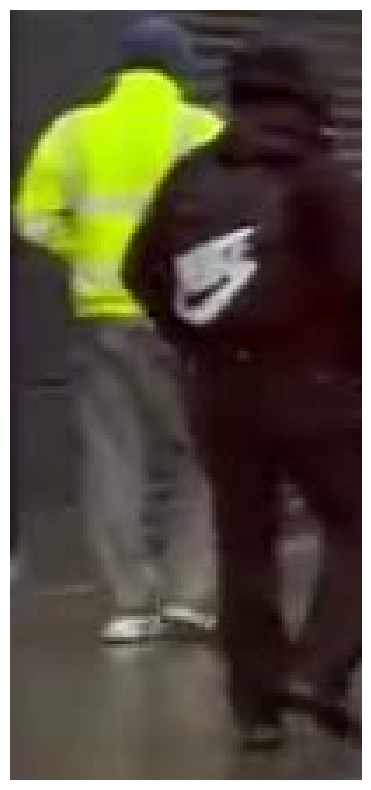

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

To generate masks, just run `generate` on an image.

In [25]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [26]:
print(len(masks))
print(masks[0].keys())

22
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


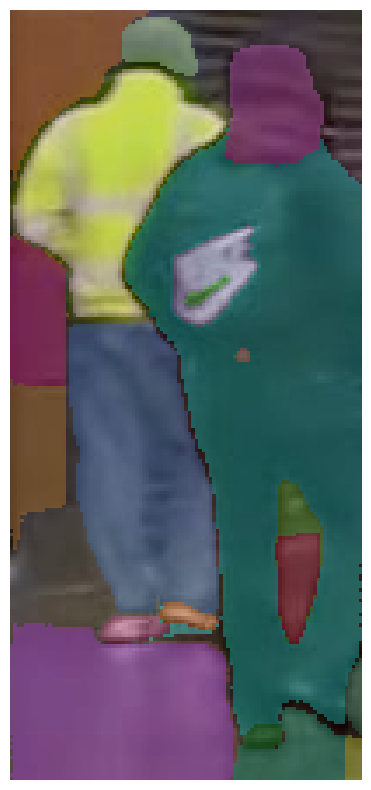

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

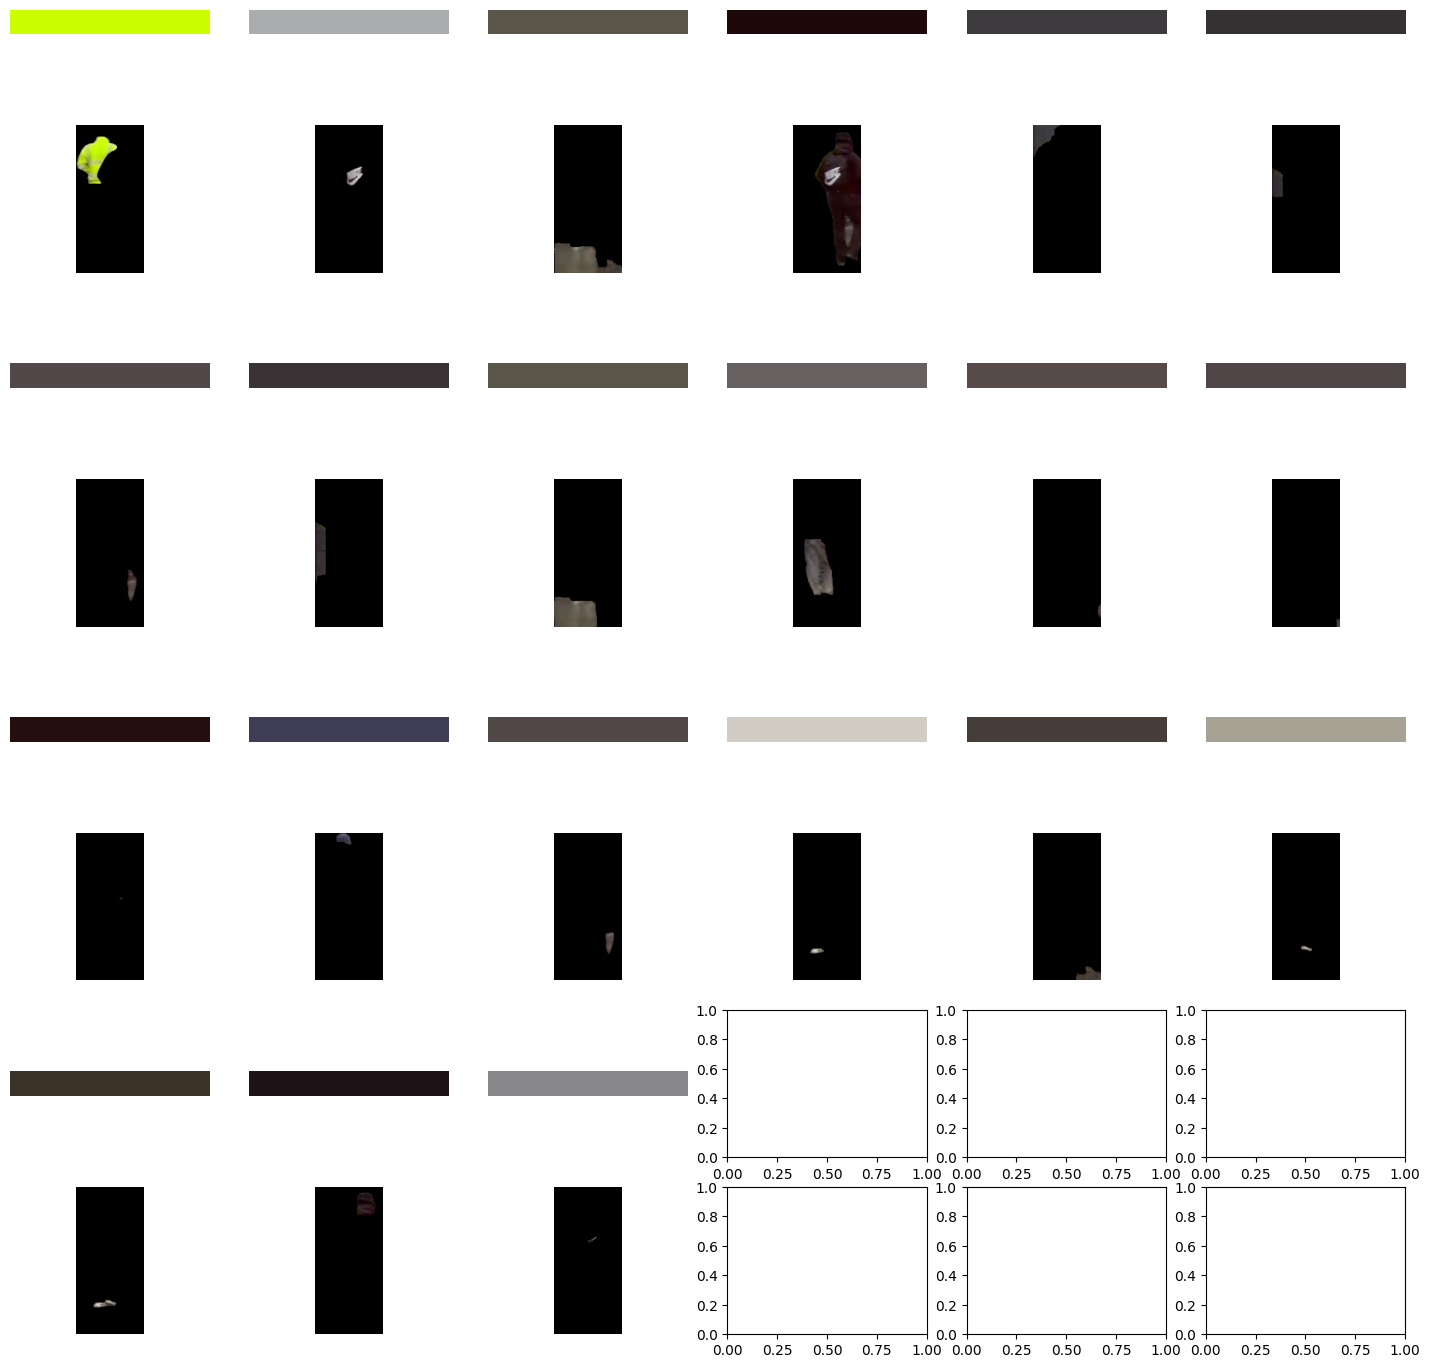

'\naxs = axs.flatten()\nfor img, ax in zip(output_images, axs):\n    ax.imshow(img)\n    ax.axis("off")\n    #show_anns(masks[i:i+1])\n    i += 1\nplt.show()\n'

In [28]:
import math
num_cols = 6
num_rows = int(math.ceil(2*len(masks)/num_cols))
output_images = []
color_images = []
for idx in range(len(masks)):
  mask = masks[idx]['segmentation']
  output_image = np.zeros_like(image)
  # Copy the pixels from the input image where the mask is True to the output image.
  output_image[mask] = image[mask]
  pil_img = Image.fromarray(output_image)
  dom_color = sorted(pil_img.getcolors(2 ** 24), reverse=True)[1][1]


  color_image = np.zeros((10, 80, 3), np.uint8)
  color_image[:] = dom_color
  color_images.append(color_image)
  output_images.append(output_image)


_, axs = plt.subplots(num_rows, num_cols, figsize=(18, 18))
i = 0

for i in range(int(num_rows/2)):
  for j in range(num_cols):
    image_idx = i*num_cols + j
    if image_idx >= len(output_images) - 1:
      break
    axs[2*i][j].imshow(color_images[image_idx])
    axs[2*i+1][j].imshow(output_images[image_idx])


    axs[2*i][j].axis("off")
    axs[2*i + 1][j].axis("off")
plt.show()

"""
axs = axs.flatten()
for img, ax in zip(output_images, axs):
    ax.imshow(img)
    ax.axis("off")
    #show_anns(masks[i:i+1])
    i += 1
plt.show()
"""

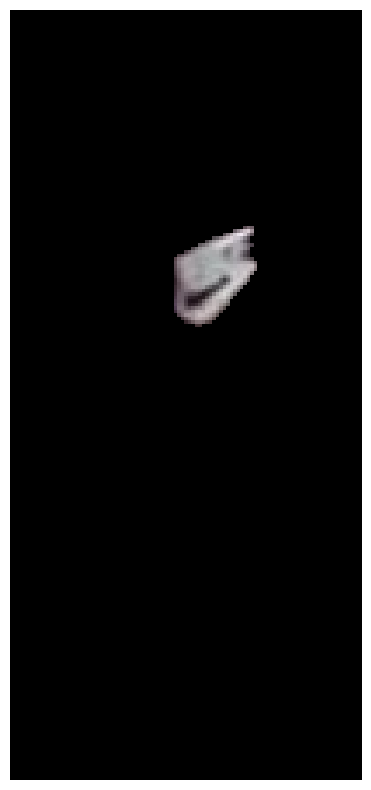

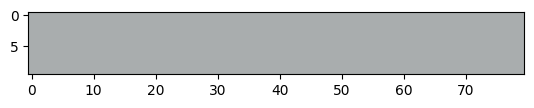

In [20]:
index = 1
plt.figure(figsize=(10,10))
plt.imshow(output_images[index])
plt.axis('off')
plt.show()

plt.imshow(color_images[index])
plt.show()

In [ ]:
masks_by_area = sorted(masks, key=lambda x: x['area'])

In [ ]:
masks_by_area[-1]['segmentation'].shape, image.shape

((390, 170), (390, 170, 3))

In [ ]:
largest_mask = masks_by_area[-1]['segmentation']

In [ ]:
img_area = np.zeros_like(image)
test_mask = masks_by_area[-4]['segmentation']
# Copy the pixels from the input image where the mask is True to the output image.
img_area[test_mask] = image[test_mask]
pil_img = Image.fromarray(img_area)

In [ ]:
masks_by_area[-1]['bbox'], masks_by_area[-4]['bbox']

([5, 43, 123, 305], [7, 203, 106, 121])

In [ ]:
masks_by_area[-4]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 5605,
 'bbox': [7, 203, 106, 121],
 'predicted_iou': 1.0044058561325073,
 'point_coords': [[23.90625, 286.40625]],
 'stability_score': 0.9727592468261719,
 'crop_box': [0, 0, 170, 390]}

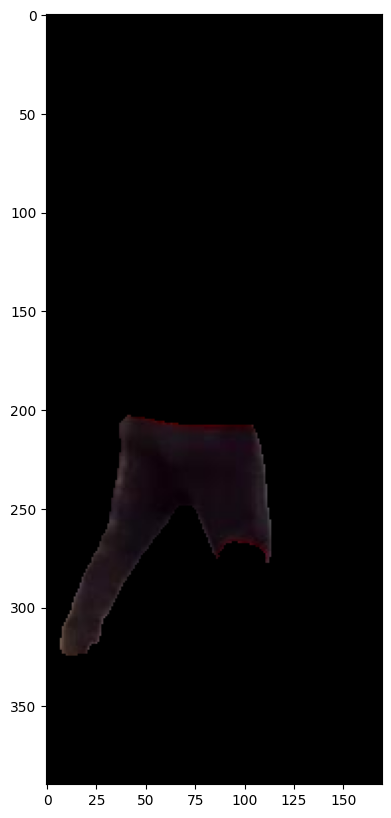

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(pil_img)
plt.show()

In [ ]:
from PIL import Image
pil_img = Image.fromarray(test_img)
dom_color = sorted(pil_img.getcolors(2 ** 24), reverse=True)[1]
dom_color

(20, (102, 96, 96))

Show all the masks overlayed on the image.

In [ ]:
"""
first plot color images
then plot masks

"""

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

229

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.